In [1]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, ClusterCentroids, TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE, SVMSMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score


train_encoded = pd.read_csv('train_encoded.csv')
test_encoded = pd.read_csv('test_encoded.csv')

In [2]:
# Check for non-numeric columns in train and test
non_numeric_train = train_encoded.select_dtypes(include=['object', 'category']).columns
non_numeric_test = test_encoded.select_dtypes(include=['object', 'category']).columns

# Combine to see any remaining unique ones
remaining_to_encode = set(non_numeric_train).union(set(non_numeric_test))

print("Remaining columns to encode:", remaining_to_encode)

Remaining columns to encode: set()


In [3]:
import pandas as pd

# Calculate the class distribution
class_distribution = train_encoded['PotentialFraud'].value_counts().reset_index()
class_distribution.columns = ['PotentialFraud', 'Count']

# Calculate the percentage of each class
class_distribution['Percentage'] = (class_distribution['Count'] / class_distribution['Count'].sum()) * 100

# Display the table
print(class_distribution)

   PotentialFraud   Count  Percentage
0               0  345024    61.90859
1               1  212288    38.09141


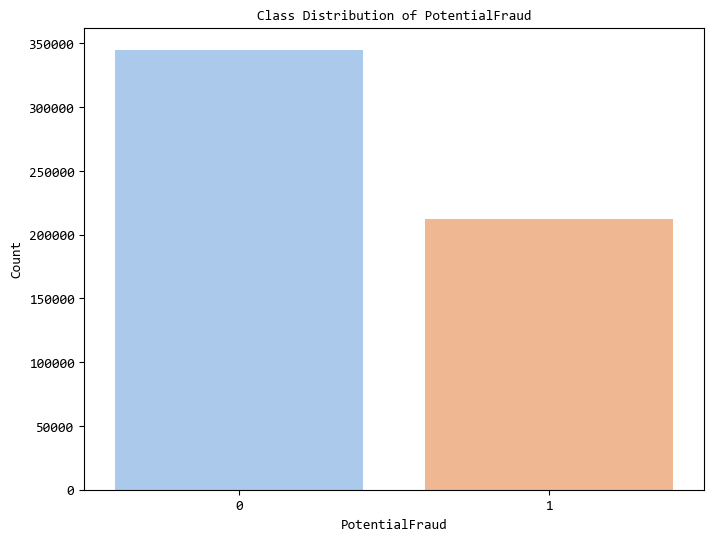

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the class distribution
plt.figure(figsize=(8,6))
sns.countplot(x='PotentialFraud', data=train_encoded, hue='PotentialFraud', palette='pastel', legend=False)
plt.title('Class Distribution of PotentialFraud', fontsize=10, fontname='Consolas')
plt.xlabel('PotentialFraud', fontsize=10, fontname='Consolas')
plt.ylabel('Count', fontsize=10, fontname='Consolas')

# Customize tick parameters
plt.xticks(fontsize=10, fontname='Consolas')
plt.yticks(fontsize=10, fontname='Consolas')

# Show plot
plt.show()

In [5]:
import numpy as np
import pandas as pd

def check_dataset_issues(dataset, dataset_name="Dataset"):
  
    # Check for NaN, Inf, and Negative values in the dataset
    issues = {
        'NaN Values': dataset.isna().sum(),
        'Inf Values': np.isinf(dataset).sum(),
        'Negative Values': (dataset < 0).sum()
    }
    
    # Create a DataFrame of the issues
    issues_df = pd.DataFrame(issues)
    
    # Filter columns with any issues
    issues_df = issues_df[issues_df.sum(axis=1) > 0]
    
    # Transpose for better readability
    issues_df = issues_df.T
    
    # Display the results
    print(f"\n{dataset_name} Issues:")
    display(issues_df)
    return issues_df

In [6]:
# Check issues in train dataset
train_issues = check_dataset_issues(train_encoded, "Train Dataset")


Train Dataset Issues:


,IPAnnualReimbursementAmt,OPAnnualReimbursementAmt,ReimbursementDeductibleRatio
NaN Values,0,0,18665
Inf Values,0,0,478036
Negative Values,57,15,0


In [7]:
# Check issues in test dataset
test_issues = check_dataset_issues(test_encoded, "Test Dataset")


Test Dataset Issues:


,IPAnnualReimbursementAmt,OPAnnualReimbursementAmt,ReimbursementDeductibleRatio
NaN Values,0,0,4458
Inf Values,0,0,116253
Negative Values,11,4,0


In [8]:
# Drop 'ReimbursementDeductibleRatio' column from both train and test datasets
train_encoded.drop(columns='ReimbursementDeductibleRatio', inplace=True)
test_encoded.drop(columns='ReimbursementDeductibleRatio', inplace=True)

In [9]:
# Define target and features
X = train_encoded.drop(columns='PotentialFraud')
y = train_encoded['PotentialFraud']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Scale the features to avoid convergence issues with some models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define balancing techniques
smote = SMOTE(random_state=42)
ros = RandomOverSampler(random_state=42)
adasyn = ADASYN(random_state=42)
borderline_smote = BorderlineSMOTE(random_state=42)
svm_smote = SVMSMOTE(random_state=42)

# Apply each balancing technique
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
X_train_ros, y_train_ros = ros.fit_resample(X_train_scaled, y_train)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)
X_train_borderline_smote, y_train_borderline_smote = borderline_smote.fit_resample(X_train_scaled, y_train)
X_train_svm_smote, y_train_svm_smote = svm_smote.fit_resample(X_train_scaled, y_train)

In [11]:
# Apply each balancing technique
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [12]:
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [ ]:
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

In [ ]:
X_train_borderline_smote, y_train_borderline_smote = borderline_smote.fit_resample(X_train, y_train)

In [ ]:
X_train_svm_smote, y_train_svm_smote = svm_smote.fit_resample(X_train, y_train)

In [ ]:
# Apply different resampling techniques
resamplers = {
    'SMOTE': (X_train_smote, y_train_smote),
    'Random OverSampling': (X_train_ros, y_train_ros),
    'ADASYN': (X_train_adasyn, y_train_adasyn),
    'Borderline SMOTE': (X_train_borderline_smote, y_train_borderline_smote),
    'SVM SMOTE': (X_train_svm_smote, y_train_svm_smote)
}

In [ ]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'CatBoost': cb.CatBoostClassifier(silent=True),
    'Decision Tree': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier(),
}

In [12]:
# evaluate models
def evaluate_model(X_train, y_train, X_test, y_test, model_name, model, sampler_name=None, sampler=None):
    if sampler:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
    
    model.fit(X_res, y_res)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Model: {model_name}")
    if sampler_name:
        print(f"Using: {sampler_name} resampling")
    print(f"Accuracy: {accuracy}")
    print(f"ROC AUC: {roc_auc}")
    print(f"Classification Report:\n{report}")
    print("-" * 50)

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress convergence warnings to avoid clutter
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Evaluate each model on every balanced dataset
print("🔍 Starting model evaluation on all balanced datasets...\n")

# Loop through all resampling techniques
for technique_name, (X_bal, y_bal) in tqdm(resamplers.items(), desc="Resampling Techniques", unit="technique"):
    print(f"\n📊 Evaluating Models for: {technique_name}\n{'-'*50}")

    # Loop through all models
    for model_name, model in models.items():
        print(f"\n➡️ Training model: {model_name}")

        # Try training the model with exception handling
        try:
            # Train the model on the balanced dataset
            model.fit(X_bal, y_bal)

            # Predict using the test set
            y_pred = model.predict(X_test_scaled)

            # Calculate accuracy
            acc = accuracy_score(y_test, y_pred)
            print(f"✅ Accuracy: {acc:.4f}")

            # Display detailed classification report
            print(f"\n📝 Classification Report for {model_name}:\n")
            print(classification_report(y_test, y_pred))
        
        except ConvergenceWarning:
            print(f"⚠️ WARNING: The model did not converge for {model_name} using {technique_name}. Consider increasing max_iter or scaling the data.")

print("\n✅ All model evaluations complete.")



--------------------------------------------------
Evaluating Logistic Regression with RandomUnderSampler resampling technique
--------------------------------------------------


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Using: RandomUnderSampler resampling
Accuracy: 0.7930344598656056
ROC AUC: 0.7771454116381642
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83     68998
           1       0.74      0.71      0.72     42465

    accuracy                           0.79    111463
   macro avg       0.78      0.78      0.78    111463
weighted avg       0.79      0.79      0.79    111463

--------------------------------------------------
--------------------------------------------------

--------------------------------------------------
Evaluating KNN with RandomUnderSampler resampling technique
--------------------------------------------------
Model: KNN
Using: RandomUnderSampler resampling
Accuracy: 0.6313485192395683
ROC AUC: 0.6200551742648934
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.67      0.69     68998
           1       0.51    

In [ ]:
# Evaluate without balancing as a baseline
for model_name, model in models.items():
    evaluate_model(X_train, y_train, X_test, y_test, model_name, model)